# Qiskit code for computing the vev of conserved charges

This code supports three types of simulation:
- noiseless simulation  
- noisy simulation  
- simulation with mocking device with readout error mitigation  

To execute this code, one should put the data file for the charge densities in the folder ./MEAS_MATERIAL.

For the simulation on 6 site, for Neel state, with 10,000 shots and 5 Trotter steps,
- it takes ~20 seconds for Q1+ with AerSimulator  
- it takes ~6 minutes for Q2+ with AerSimulator  
- it takes ~90 seconds for Q1+ with FakeGuadalupe  
- it takes ~12 minutes for Q2+ with FakeGuadalupe  

For the simulation on 6 site, for Neel state, with 100,000 shots and 5 Trotter steps,
- it takes ~90 seconds for Q1+ with AerSimulator  
- it takes ~13 minutes for Q2+ with AerSimulator  

We used Using 2.9 GHz 6-Core Intel Core i9.

In [1]:
## check qiskit version
# !python3 -m pip show qiskit

In [2]:
## import libraries
from qiskit import *

from qiskit.circuit import Parameter
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
from qiskit.test.mock import FakeGuadalupe  # import appropriate mocking devices
from qiskit.tools.visualization import plot_histogram
from qiskit.utils.mitigation import (complete_meas_cal,CompleteMeasFitter)
from qiskit.visualization import plot_histogram

from math import tan
import matplotlib.pyplot as plt
import datetime, os, re
import numpy as np

## time stamp
dt1=datetime.datetime.now()
dt_now=datetime.datetime.now().strftime('%m%d_%H%M_%S')
print(dt1)

2022-07-27 03:18:43.287429


## Configuration and Parameters

In [3]:
site_num = 6
alpha_param = 0.3
trotter_step = 5
shot = 100000

initial_state = 'Neel'  #Neel' or 'all_zero' 
degree_of_charge_density = 2  # 1 or 2

using_mocking_simulator = False
measurement_error_mitigation = False
name_mock_backend = 'FakeGuadalupe()'
optimization_level = 1  # 0 to 3

noise_model_type = 'None' #'None' depo' or 'damp
basis_gates = ['u1', 'u2', 'u3', 'cx'] 
q1_depo_rate = 0.0
q2_depo_rate = 0.001
amp_damp_rate = 0.018
phase_damp_rate = 0.018

In [4]:
## Consistency check
if site_num < 2*degree_of_charge_density+1:
    print("Warning! charge degree is too large")
    exit()

if measurement_error_mitigation and not using_mocking_simulator:
    print('Warning: error mitigation incompatible with simulator\n')
    exit()

## Observable
Input data is the charge density. We need to sum over its spatial coordinate by shifting the indices

In [5]:
### Read the file corresponding to the observable to be measured
if degree_of_charge_density == 1:
    g = open('MEAS_MATERIAL/q1_plus_coefficients.dat', 'r')
elif degree_of_charge_density == 2:
    g = open('MEAS_MATERIAL/q2_plus_coefficients.dat', 'r')
else:
    print("No such file")
meas_list = list(g.readlines())
g.close()

## Noise model and Backend

In [6]:
def generate_noise_model(site):
    ### Defining the Noise Model
    if noise_model_type == 'depo':
        error_depo1 = depolarizing_error(q1_depo_rate, 1)
        error_depo2 = depolarizing_error(q2_depo_rate, 2)
    elif noise_model_type == 'damp':
        error_damp = phase_amplitude_damping_error(amp_damp_rate, phase_damp_rate)

    ### Add errors to noise model
    if noise_model_type == 'depo':
        noise_model = NoiseModel(basis_gates=basis_gates)
        noise_model.add_all_qubit_quantum_error(error_depo1, ["u1", "u2", "u3"])
        noise_model.add_all_qubit_quantum_error(error_depo2, ["cx"])
    elif noise_model_type == 'damp':
        noise_model = NoiseModel(basis_gates=basis_gates)
        noise_model.add_all_qubit_quantum_error(error_damp.tensor(error_damp), ["cx"])

    print(noise_model)
    return AerSimulator(noise_model=noise_model)

In [7]:
### Define backend device
if using_mocking_simulator:
    mssg="mock_backend="+name_mock_backend
    exec(mssg)
    device = mock_backend
elif not noise_model_type == 'None':
    device = generate_noise_model(site_num)  
else:
    device = Aer.get_backend('qasm_simulator')

## Filter for the measurement error mitigation

In [8]:
def generate_meas_filter(site, mock_backend, shot=10000):
    qr_mem = QuantumRegister(site)
    meas_calibs, state_labels = complete_meas_cal(qr=qr_mem, circlabel='mcal')
    job = execute(meas_calibs, backend=mock_backend, shots=shot)
    cal_results = job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter
    return meas_filter

if measurement_error_mitigation:
    meas_filter = generate_meas_filter(site_num, mock_backend)

## R-matrix with parameter $\alpha$

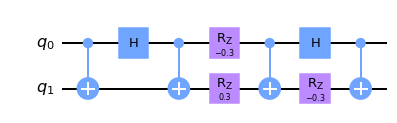

In [9]:
R = QuantumCircuit(2, name='R')

R.cx(0,1)
R.h(0)
R.cx(0,1)
R.rz(-alpha_param, 0)
R.rz(alpha_param, 1)
R.cx(0,1)
R.h(0)
R.rz(-alpha_param, 1)
R.cx(0,1)

R.draw('mpl')

## Trotter time evolution

In [10]:
###     Main Circuit
delta = tan(alpha_param)
interaction = 2*degree_of_charge_density+1
ans_list = []

for step in range(trotter_step+1):
    charge_dens_list = []
    
    for spatial in range(site_num//2):
        charge_dens_meas = 0.0
        
        # spatial coordinate of the charge density
        target = [(2*spatial+x)%site_num for x in range(interaction)]

        for meas in meas_list:
            # Density data
            ind, coef, prod = re.split(r'\t+', meas.rstrip('\n'))
            ind = int(ind)
            coef = int(coef)

            qr = QuantumRegister(site_num, name='qr')
            cr = ClassicalRegister(site_num, name='cr')
            qc = QuantumCircuit(qr,cr, name='qc')  

            # Initial State
            if initial_state == 'Neel':
                for l in range(0, site_num, 2):
                    qc.x(l)

            # Evolution
            for _ in range(step):
                for i in range(0,site_num,2):
                    qc.append(R.to_instruction(), [qr[i], qr[i+1]])
                for i in range(0,site_num,2):
                    qc.append(R.to_instruction(), [qr[i+1], qr[(i+2)%site_num]])

            for i in range(0,interaction):
                if prod[i] == 'X':
                    qc.h(target[i])
                elif prod[i] == 'Y':
                    qc.sdg(target[i])
                    qc.h(target[i])
            
            qc.measure(qr,cr[::-1])
            job = execute(qc, backend=device, shots=shot, optimization_level=optimization_level)
            result = job.result()
            if measurement_error_mitigation:
                result = meas_filter.apply(result)
            counts = result.get_counts(qc)

            meas_ans = 0.0
            for b, counts_b in counts.items():
                meas_res = 1.0
                for i in range(interaction):
                    if prod[i] != 'I':
                        meas_res *= (1 - 2*int(b[target[i]]))
                meas_res = meas_res * counts_b/shot
                meas_ans += meas_res

            charge_dens_meas += delta**ind * coef * meas_ans

        charge_dens_list.append(charge_dens_meas)
    
    Qnp = sum(charge_dens_list)
    ans_list.append(Qnp)
    print('d={} {}'.format(step, Qnp))


d=0 5.580234061543674
d=1 5.5562201347208955
d=2 5.578547975242382
d=3 5.558099603301703
d=4 5.618296287694478
d=5 5.5917653870696995


## Plot the answer

plot_Q2_6site_0727_0318_43.pdf


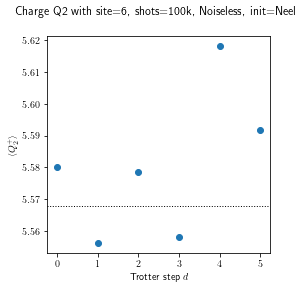

In [11]:
## Plot the data
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

colormap = plt.get_cmap("tab10")
markers = ["o","x","s","^","+","*"]
ylabel = r"$\langle Q_{}^+\rangle$".format(degree_of_charge_density)

steps = range(trotter_step+1)
vals = np.array(ans_list)

plt.plot(steps, vals, color=colormap(0), marker=markers[0], linestyle="none")

if degree_of_charge_density == 1:
    if initial_state == 'Neel':
        plt.axhline(y=site_num*(-2+delta**2)/2, color='black', linestyle=':', linewidth=1)
    elif initial_state == 'all_zero':
        plt.axhline(y=(2+delta**2)*site_num/2, color='black', linestyle=':', linewidth=1)
elif degree_of_charge_density == 2:
    if initial_state == 'Neel':
        plt.axhline(y=3*site_num*delta, color='black', linestyle=':', linewidth=1)
    elif initial_state == 'all_zero':
        # this value is for alpha=0.3
        plt.axhline(y=-site_num*delta, color='black', linestyle=':', linewidth=1)

if noise_model_type == 'damp':
    plt.suptitle('Charge Q{} with site={}, shots={}k, damp={}, init={}'\
                 .format(degree_of_charge_density,site_num,shot//1000,amp_damp_rate,initial_state))
elif noise_model_type == 'depo':
    plt.suptitle('Charge Q{} with site={}, shots={}k, depo={}, init={}'\
                 .format(degree_of_charge_density,site_num,shot//1000,q2_depo_rate,initial_state))
elif using_mocking_simulator == True:
    plt.suptitle('Charge Q{} with site={}, shots={}k, {}, init={}'\
                 .format(degree_of_charge_density,site_num,shot//1000,name_mock_backend,initial_state))
else:
    plt.suptitle('Charge Q{} with site={}, shots={}k, Noiseless, init={}'\
                 .format(degree_of_charge_density,site_num,shot//1000,initial_state))

plt.xlabel("Trotter step $d$")
plt.ylabel(ylabel)


fig = plt.gcf()
fig.set_size_inches(4,4)
file_name = 'plot_Q{}_{}site_{}.pdf'.format(degree_of_charge_density,site_num,dt_now)
print(file_name)
plt.savefig(file_name)

In [12]:
dt2=datetime.datetime.now()
print(dt2-dt1)

os.system("say 'finished'")
#os.system("/usr/bin/canberra-gtk-play --id='system-ready'")

0:12:42.620472


0